# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

a-0.png
a-1.png
a-10.png
a-11.png
a-12.png
a-13.png
a-2.png
a-3.png
a-4.png
a-5.png
a-6.png
a-7.png
a-8.png
a-9.png


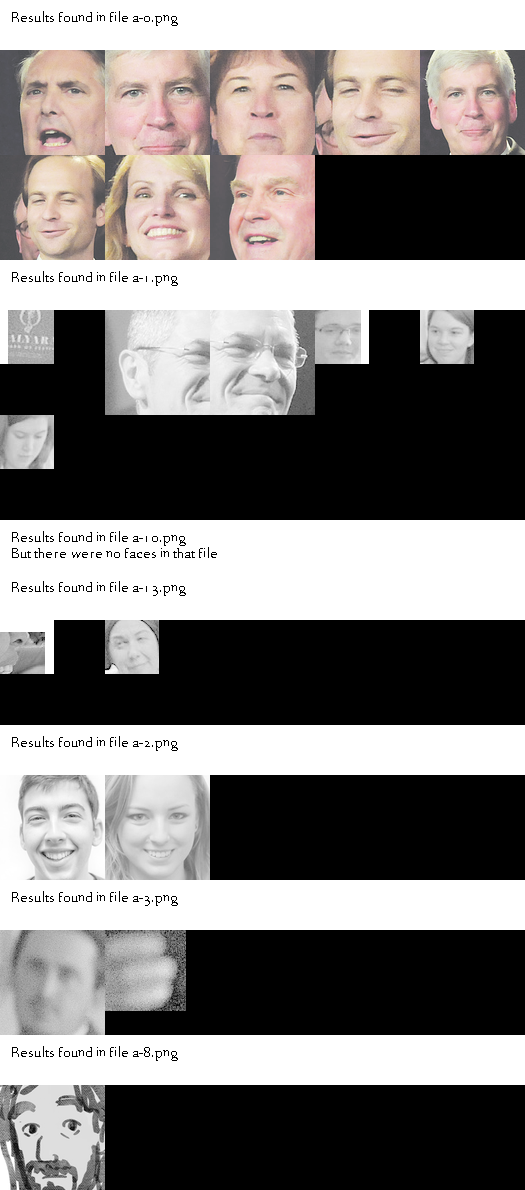

In [2]:
import zipfile

from zipfile import ZipFile
from PIL import Image, ImageDraw, ImageFont
import pytesseract
import cv2 as cv
import numpy as np

# loading the face detection classifier
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')
fnt = ImageFont.truetype('readonly/fanwood-webfont.ttf', 16)

# work in zip file
with ZipFile("readonly/images.zip") as my_zip:
    # list files
    files = my_zip.infolist()
    file_names = my_zip.namelist()    
    all_out_imgs = []

    # iterate in every image
    for i in range(len(files)):
        image = Image.open(my_zip.open(files[i]))        
        image = image.convert("RGB")
        gray_img = image.convert("L")
        # OCR
        text = pytesseract.image_to_string(gray_img)
        print(file_names[i])        
        # check if key-word detected
        if "Mark" in text:
            # face recognision
            cv_img = np.array(gray_img)
            faces = face_cascade.detectMultiScale(cv_img, 1.5)
            faces_imgs = []
            for x,y,w,h in faces:            
                faces_imgs.append(image.crop((x,y,x+w,y+h)))
            
            # check if face detected
            if len(faces_imgs) > 0:
                # create text image
                txt_img = Image.new("1", (525, 50), color = 1)
                txt_label = "Results found in file {}".format(str(file_names[i]))
                ImageDraw.Draw(txt_img).text((10,10), txt_label, font=fnt, fill = 0) 
                txt_img = txt_img.convert("RGB")
                # resize faces_imgs
                for index, item in enumerate(faces_imgs):
                    if item.width <= 105:
                        pass
                    else:
                        faces_imgs[index] = item.resize((105, 105), Image.ANTIALIAS)
                # paste faces_imgs
                row_num = int(np.ceil(len(faces_imgs) / 5))
                face_all_img = Image.new("RGB", (525, 105*row_num))
                x = 0
                y = 0
                for img in faces_imgs:
                    face_all_img.paste(img, (x,y))
                    if x + 105 == 525:
                        x = 0
                        y += 105
                    else:
                        x += 105
                all_out_imgs.append(txt_img)
                all_out_imgs.append(face_all_img)
                                      
            # if face not detected
            else:  
                # create text image  
                txt_img = Image.new("1", (525, 50), color = 1)
                txt_label = "Results found in file {} \nBut there were no faces in that file".format(str(file_names[i]))
                ImageDraw.Draw(txt_img).text((10,10), txt_label, font=fnt, fill = 0)  
                txt_img = txt_img.convert("RGB")
                all_out_imgs.append(txt_img)
        
    # paste all the images
    all_out_imgs_heights = map(lambda x: x.height, all_out_imgs)
    out_img_height = 0
    for value in all_out_imgs_heights:
        out_img_height += value
    out_img = Image.new("RGB", (525, out_img_height))
    x = 0
    y = 0
    for img in all_out_imgs:
        out_img.paste(img, (x, y))
        y += img.height

    display(out_img)
    